# Phase transition


### VD algorithm

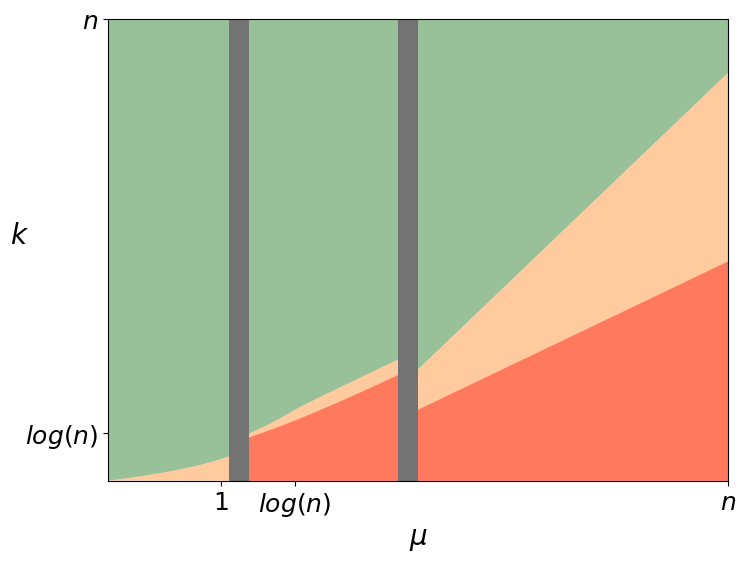

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
from scipy.special import lambertw
from matplotlib.lines import Line2D
from matplotlib.ticker import NullLocator


# Define inverse entropy functions
def H_inv(alpha):
    return np.exp(lambertw((alpha**-1 - 1) / np.e).real + 1)

def H_inv_minus(alpha):
    return np.exp(lambertw((alpha**-1 - 1) / np.e, k=-1).real + 1)

# Define T_n based on the cases
def T_n(mu_n, n, sparse_threshold=1e-1, dense_threshold=1e1):
    log_n = np.log(n)

    if mu_n < log_n * sparse_threshold:
        return log_n / np.log(log_n / mu_n), 'sparse'
    elif mu_n > log_n * dense_threshold:
        return mu_n, 'dense'
    else:
        alpha = mu_n / log_n
        return mu_n * H_inv(alpha), 'connectivity'

# Plotting function with updated curve definitions
def plot_T_n(n, st=1e-2, dt=1e2, eps=0.5):
    log_n = np.log(n)
    s = 0.1  # Coefficient for dense case

    mu_n_values = np.logspace(-2, np.log10(n), 10000)

    lower_bound_1 = st * log_n * eps
    upper_bound_1 = st * log_n / eps
    lower_bound_2 = dt * log_n * eps
    upper_bound_2 = dt * log_n / eps

    original_mu_n_values = mu_n_values

    # Compute adjusted curve values and cases
    curve_values = []
    Tn_list = []
    cases = []

    for mu in mu_n_values:
        Tn, case = T_n(mu, n, st, dt)
        alpha = mu / log_n

        if case == 'sparse':
            value = Tn  # t_n = 0
        elif case == 'connectivity':
            if alpha < 1:
                t_n = 0
            else:
                t_n = mu * H_inv_minus(alpha)
            value = Tn - t_n
        elif case == 'dense':
            value = s * mu

        curve_values.append(value)
        Tn_list.append(Tn)
        cases.append(case)

    curve_values = np.array(curve_values)
    Tn_list = np.array(Tn_list)
    cases = np.array(cases)

    # Plotting
    plt.figure(figsize=(8, 6))
    curve_colors = {'sparse': '#5BE95B', 'connectivity': '#32A032', 'dense': '#325032'}
    green_color = '#006401'
    orange_color = 'C1'
    grey_color = '#737373'

    for case in ['sparse', 'connectivity', 'dense']:
        mask = cases == case
        plt.fill_between(mu_n_values[mask], curve_values[mask], np.min(curve_values), color=orange_color, alpha=0.4, edgecolor=None)
        plt.fill_between(mu_n_values[mask], curve_values[mask], n, color=green_color, alpha=0.4, edgecolor=None)
        #plt.scatter(mu_n_values[mask], curve_values[mask], color=curve_colors[case], marker='s', label=r'$T_n$'+f" {case}", alpha=1, s=5)


    # Fill red area UNDER the curve T_n - mu (only for connectivity regime)
    mask_connectivity = cases == 'connectivity'
    plt.fill_between(mu_n_values[mask_connectivity],
                     0,  # from y=0
                     Tn_list[mask_connectivity] - mu_n_values[mask_connectivity],
                     color='red', alpha=0.4, edgecolor=None)

    # Fill red area UNDER the curve sqrt(mu) (only for dense regime)
    mask_connectivity = cases == 'dense'
    plt.fill_between(mu_n_values[mask_connectivity],
                     0,  # from y=0
                     np.sqrt(mu_n_values[mask_connectivity]),
                     color='red', alpha=0.4, edgecolor=None)


    # Fill grey exclusion zones
    plt.fill_between(original_mu_n_values[
        ((original_mu_n_values >= lower_bound_1) & (original_mu_n_values <= upper_bound_1))
    ], np.min(curve_values), n, color=grey_color, alpha=1, edgecolor=None)

    plt.fill_between(original_mu_n_values[
        ((original_mu_n_values >= lower_bound_2) & (original_mu_n_values <= upper_bound_2))
    ], np.min(curve_values), n, color=grey_color, alpha=1, edgecolor=None)

    # Vertical dotted line at mu = log(n)
    #plt.axvline(x=log_n, color='black', linestyle=':', linewidth=3)

    # Axis settings
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$\mu$', fontsize=20)
    plt.ylabel(r'$k$', fontsize=20, rotation=0)
    #plt.title(f'VD-algorithm ($n = 10^{int(np.log10(n))}$)', fontsize=24)

    plt.gca().yaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_minor_locator(NullLocator())

    custom_ticks = [1, log_n, n]
    plt.xticks(custom_ticks, ["1", f'$log(n)$', f'$n$'])
    plt.yticks(custom_ticks, ["1", f'$log(n)$', f'$n$'])

    legend_elements = [
        Line2D([0], [0], color=curve_colors['sparse'], lw=5, markersize=8, linestyle='-', label=r'$T_n$ sparse'),
        Line2D([0], [0], color=curve_colors['connectivity'], lw=5, markersize=8, linestyle='-', label=r'$T_n$ connectivity'),
        Line2D([0], [0], color=curve_colors['dense'], lw=5, markersize=8, linestyle='-', label=r'$T_n$ dense')
    ]
    #plt.legend(handles=legend_elements, fontsize=18, loc=2, framealpha=1)

    plt.grid(False)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.xlim(min(mu_n_values), max(mu_n_values))
    plt.ylim(min(curve_values), n)

    plt.savefig('positive_VD.png', dpi=600, bbox_inches='tight')
    plt.show()

# Example usage
n = 1e9
sparse_threshold = 1e-1
dense_threshold = 1e2
eps = 4/6
plot_T_n(n, sparse_threshold, dense_threshold, eps)


### CN algorithm

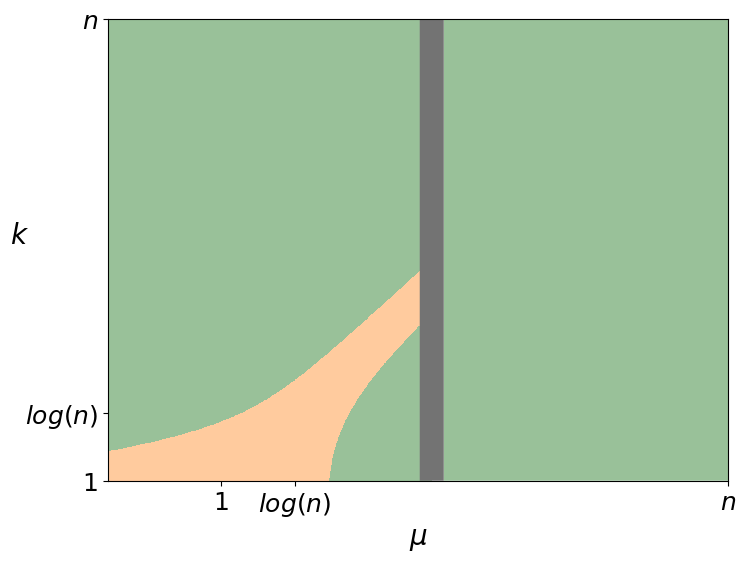

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
from scipy.special import lambertw  # Import the Lambert W function
from matplotlib.ticker import NullLocator

# The logarithmic form of Stirling's approximation
def log_stirling_approx(y):
    """Calculate the logarithmic approximation of y! using Stirling's formula."""
    return 0.5 * np.log(2 * np.pi * y) + y * np.log(y / np.e)

# The logarithmic form of f(x, y) defined piecewise
def log_f(x, y):
    """Calculate the logarithm of f(x, y) based on different regions."""
    C = 0.391
    log_f_value = np.zeros_like(x)

    # When y > x
    mask1 = y > x
    log_f_value[mask1] = log_stirling_approx(y[mask1]) - np.log(x[mask1]) - y[mask1] * np.log(x[mask1]) - x[mask1]

    # When y < C * x
    mask2 = (y < C * x) & ~mask1
    log_f_value[mask2] = log_stirling_approx(y[mask2]) - np.log(x[mask2]) - y[mask2] * np.log(C * x[mask2]) + C * x[mask2]

    # Otherwise
    mask3 = ~mask1 & ~mask2
    log_f_value[mask3] = log_stirling_approx(y[mask3]) - np.log(x[mask3]) - y[mask3] * np.log(y[mask3] / np.e)

    return log_f_value

def CN_algo_phase_transition(n, log_scale=True):
    """Plot the phase transition of log(f(x, y)) as a function of x and y, and save the plot as a PNG."""

    # Increase font size globally
    plt.rcParams.update({'font.size': 18})

    # Compute and plot the vertical line at x = -W_{-1}(-c/n) / c
    c_value = (np.sqrt(3) / (3 * np.pi)) - (1 / (2 * np.pi))  # Constant c
    x_line = lambertw(-c_value / n, k=-1).real / (-c_value)
    #plt.axvline(x=x_line, color='C0', linestyle='--', label='x = -W_{-1}(-c/n) / c')

    # Define the range for x and y (start from 10^1 = 10 to avoid log(0))
    x_values = np.logspace(-2, np.log10(5*x_line), 1000) if log_scale else np.linspace(10, n, 1000)
    y_values = np.logspace(0, np.log10(n), 1000) if log_scale else np.linspace(10, n, 1000)

    # Create meshgrid for x and y
    X, Y = np.meshgrid(x_values, y_values)

    # Calculate log(f(x, y)) over the grid
    Z_log = log_f(X, Y)

    # Threshold value: log(50) + log(n)
    threshold = np.log(50) + np.log(n)

    green_color = '#006401'
    orange_color = 'C1' #'#fea500'
    grey_color = '#737373'

    # Define custom colors
    colors = [orange_color, green_color]  # Red for failure, green for success
    cmap = ListedColormap(colors)


    # Plot the contour with the chosen scale


    plt.figure(figsize=(8, 6))
    #contour = plt.contourf(X, Y, Z_log, levels=[Z_log.min(), threshold, Z_log.max()], cmap=cmap, alpha=0.4, antialised=False, linewidth=0)
    plt.pcolormesh(X, Y, Z_log > threshold, cmap=cmap, alpha=0.4, shading="auto")

    # Set the axes' scale based on the log_scale parameter
    if log_scale:
        plt.xscale('log')
        plt.yscale('log')
    else:
        plt.xscale('linear')
        plt.yscale('linear')

    # Compute and plot the vertical line at x = -W_{-1}(-c/n) / c
    c_value = (np.sqrt(3) / (3 * np.pi)) - (1 / (2 * np.pi))  # Constant c
    x_line = lambertw(-c_value / n, k=-1).real / (-c_value)
    #plt.vlines(x=x_line, ymin=1, ymax=n, color='black', linestyle=':', linewidth=3)

    # Color the region to the right of the x_line in green
    plt.fill_betweenx(y_values, 8*x_line, n, color=green_color, alpha=0.4, edgecolor=None)

    plt.fill_betweenx(y_values, 3*x_line, 8*x_line, color=grey_color, alpha=1, edgecolor=None)


    # Set labels and title with increased font size
    #plt.title(f'CN-algorithm ($n = 10^{int(np.log10(n))}$)', fontsize=24)
    plt.xlabel(r'$\mu$', size=20)
    plt.ylabel(r'$k$', size=20, rotation=0)

    # Remove grid lines
    plt.grid(False)

    # Set custom ticks at 1, log(n), and n
    plt.gca().yaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_minor_locator(NullLocator())

    #plt.xticks([1, np.log(n), x_line, n], ['1',f'$log(n)$', r'$\frac{-W(-c_1/n)}{c_1}$', f'$n$'])
    plt.xticks([1, np.log(n), n], ['1',f'$log(n)$', f'$n$'])
    plt.yticks([1,np.log(n), n], ['1',f'$log(n)$', f'$n$'])

    plt.tick_params(axis='both', which='major', labelsize=18)

    plt.xlim(min(x_values),n)
    plt.ylim(min(y_values),max(y_values))

    # Add a legend
    #plt.legend(fontsize=14, loc='upper left')

    # Save the figure as a PNG file with 300 DPI
    plt.savefig('positive_CN.png', dpi=600, bbox_inches='tight')

    # Show the plot
    plt.show()

CN_algo_phase_transition(1e9, log_scale=True)

# Algorithm performance

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
from random import sample
from tqdm import tqdm

### Generate graph

In [ ]:
def RGG(n, radius):

    # Step 1: Generate a random geometric graph and select clique nodes
    N = np.random.poisson(n)
    G = nx.random_geometric_graph(N, radius)

    return G

def plant_clique(G, k):

    # Step 2: Plant a clique on the first k vertices
    clique = list(range(k))
    clique_edges = list(combinations(clique, 2))
    G.add_edges_from(clique_edges)

    return G, clique

def RGG_planted_clique(n, radius, k):

    # Step 1: Generate a random geometric graph and select clique nodes
    N = np.random.poisson(n)
    G = nx.random_geometric_graph(N, radius)
    clique = list(range(k))

    # Step 2: Plant a clique on the first k vertices
    clique_edges = list(combinations(clique, 2))
    G.add_edges_from(clique_edges)

    return G, clique



### Algorithms

In [ ]:
def VD_algorithm(G, k):
    # Calculate degree for each node and sort them in descending order of degree
    degrees = dict(G.degree())
    sorted_vertices = sorted(degrees, key=degrees.get, reverse=True)
    return sorted_vertices[:k]


def CN_algorithm(G, k):
    # Check common neighbors for each edge and find the clique
    for edge in G.edges:
        a, b = edge
        common_neighbors = list(nx.common_neighbors(G, a, b))
        if len(common_neighbors) == k - 2:
            H = G.subgraph(common_neighbors)
            h = len(H.nodes)
            if H.size() == h*(h-1)/2:
                return [a, b] + common_neighbors


    # If no clique found, return random k vertices
    return sample(list(G.nodes), k)


def CC_algorithm(G, k):
    # Calculate closeness centrality for all nodes
    closeness_centrality = nx.closeness_centrality(G)

    # Sort nodes by closeness centrality in descending order
    sorted_nodes = sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True)

    # Extract the top k nodes
    top_k_nodes = [node for node, centrality in sorted_nodes[:k]]
    return top_k_nodes


def HC_algorithm(G, k):
    # Calculate harmonic centrality for all nodes
    harmonic_centrality = nx.harmonic_centrality(G)

    # Sort nodes by harmonic centrality in descending order
    sorted_nodes = sorted(harmonic_centrality.items(), key=lambda item: item[1], reverse=True)

    # Extract the top k nodes
    top_k_nodes = [node for node, centrality in sorted_nodes[:k]]
    return top_k_nodes


def BC_algorithm(G, k):
    # Calculate betweeneess centrality for all nodes
    betweeness_centrality = nx.betweenness_centrality(G)

    # Sort nodes by betweeness centrality in descending order
    sorted_nodes = sorted(betweeness_centrality.items(), key=lambda item: item[1], reverse=True)

    # Extract the top k nodes
    top_k_nodes = [node for node, centrality in sorted_nodes[:k]]
    return top_k_nodes


def LC_algorithm(G, k):
    # Calculate load centrality for all nodes
    load_centrality = nx.load_centrality(G)

    # Sort nodes by load centrality in descending order
    sorted_nodes = sorted(load_centrality.items(), key=lambda item: item[1], reverse=True)

    # Extract the top k nodes
    top_k_nodes = [node for node, centrality in sorted_nodes[:k]]
    return top_k_nodes


def check_algorithm_success(k_vertices, clique):
    # Calculate the number of top k vertices that are part of the planted clique
    return len(set(k_vertices) & set(clique)) == len(clique)

### TEST

In [ ]:
import time

n = 10000
mu = np.log(n)
r = np.sqrt(mu/(np.pi*n))
k = int(np.log(n))

t0 = time.time()
G, clique = RGG_planted_clique(n, r, k)

t1 = time.time()
VD_k_vertices = VD_algorithm(G, k)

t2 = time.time()
CN_k_vertices = CN_algorithm(G, k)

t3 = time.time()

print(f"Generate graph: {round(t1-t0,2)}")
print(f"VD algorithm: {round(t2-t1,2)}")
print(f"CN algorithm: {round(t3-t2,2)}")

Generate graph: 0.53
VD algorithm: 0.02
CN algorithm: 0.0


In [ ]:
def success_rates(n, mu, r, k_values, num_graphs):
    # Evaluate algorithms over multiple graphs for different k values
    VD_success = {k:0 for k in k_values}
    CN_success = {k:0 for k in k_values}

    for _ in tqdm(range(num_graphs)):

        G = RGG(n, r)

        for k in k_values:

            G, clique = plant_clique(G, k)

            VD_k_vertices = VD_algorithm(G, k)
            CN_k_vertices = CN_algorithm(G, k)

            VD_success[k] += check_algorithm_success(VD_k_vertices, clique)
            CN_success[k] += check_algorithm_success(CN_k_vertices, clique)


    VD = []
    CN = []

    for k in k_values:
        VD.append(VD_success[k]/num_graphs)
        CN.append(CN_success[k]/num_graphs)

    return VD, CN

def plot_success_rates(VD, CN, k_values, n, mu):
    # Plot the average success rates as k increases
    plt.figure(figsize=(12, 6))

    # Blue line: thicker with empty squares
    plt.plot(k_values, VD, label='Vertex degree', marker='s',
             markersize=12, markeredgewidth=3, markerfacecolor='white',
             linewidth=3, color='C0')

    # Orange line: thicker with empty circles
    plt.plot(k_values, CN, label='Common neighbors', marker='o',
             markersize=12, markeredgewidth=3, markerfacecolor='white',
             linewidth=3, color='C1')

    # Increase font size for labels and title
    plt.xlabel(f'$k$', fontsize=20)
    #plt.title(f'Success rate -- $\mu = {round(mu,2)}, n = {int(n)}$', fontsize=24)

    # Increase font size for legend
    plt.legend(fontsize=20)

    plt.xscale('log')

    # Increase font size for ticks
    plt.xticks([2, np.log(n), np.sqrt(n)], labels=[r'$2$', r'$\log n$', r'$\sqrt{n}$'], fontsize=20)
    plt.yticks(fontsize=20)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))  # Format as percentage

    plt.savefig(f'compare_mu{mu}', dpi=600, bbox_inches='tight')

    plt.show()

mu = 1


100%|██████████| 1000/1000 [05:56<00:00,  2.81it/s]


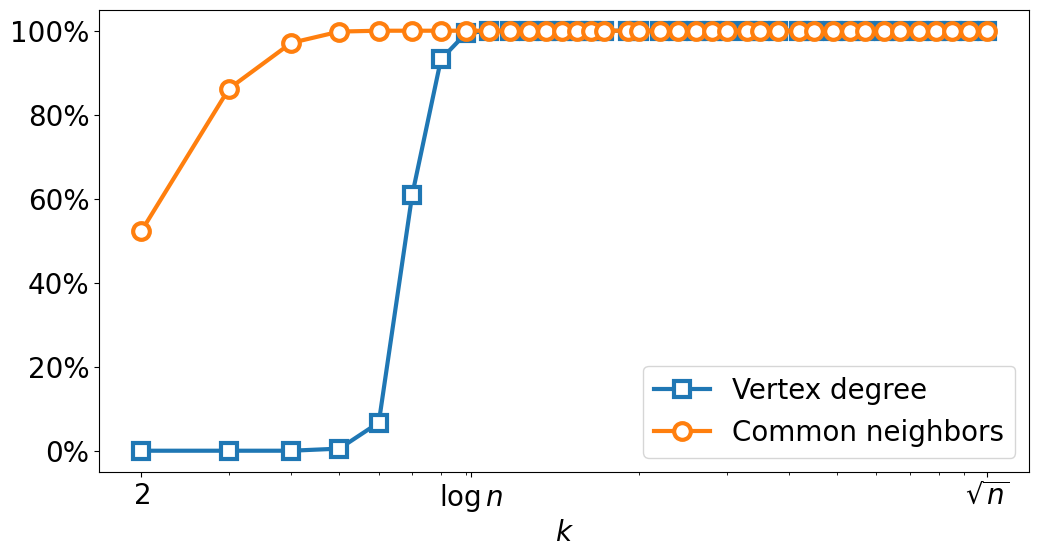

In [ ]:
# Parameters
n = 10000
mu = 1 #np.log(n)
r = np.sqrt(mu/(np.pi*n))

print(f"mu = {round(mu, 2)}")

k_values = np.logspace(np.log10(2), np.log10(np.sqrt(n)), 50)
k_values = np.unique(np.round(k_values).astype(int))    # Different sizes of the planted clique

num_graphs = 1000               # Number of graphs to generate

VD, CN = success_rates(n, mu, r, k_values, num_graphs)
plot_success_rates(VD, CN, k_values, n, mu)

mu = 5


100%|██████████| 1000/1000 [08:05<00:00,  2.06it/s]


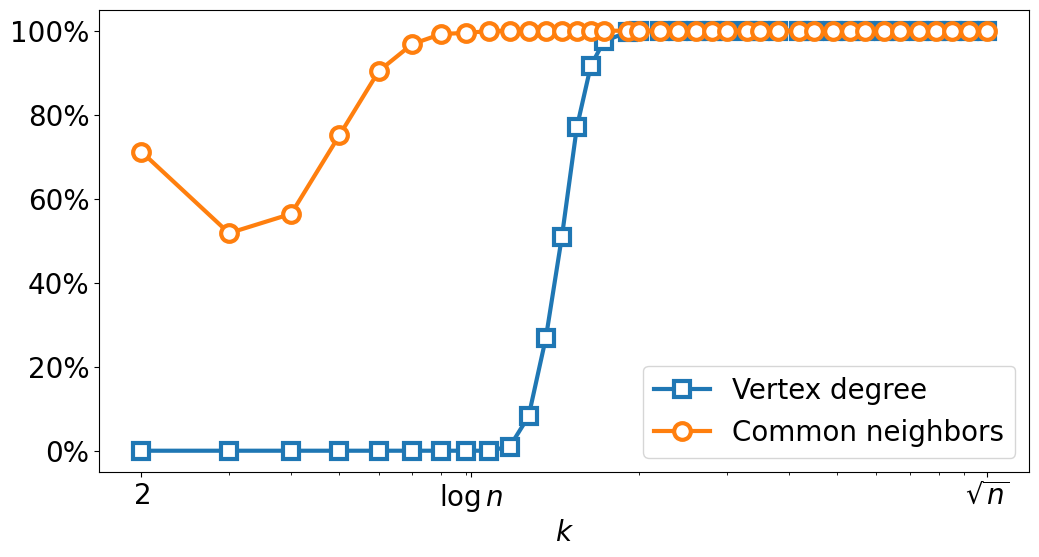

In [ ]:
# Parameters
n = 10000
mu = 5 #np.log(n)
r = np.sqrt(mu/(np.pi*n))

print(f"mu = {round(mu, 2)}")

k_values = np.logspace(np.log10(2), np.log10(np.sqrt(n)), 50)
k_values = np.unique(np.round(k_values).astype(int))    # Different sizes of the planted clique

num_graphs = 1000               # Number of graphs to generate

VD, CN = success_rates(n, mu, r, k_values, num_graphs)
plot_success_rates(VD, CN, k_values, n, mu)

mu = 20


100%|██████████| 1000/1000 [13:48<00:00,  1.21it/s]


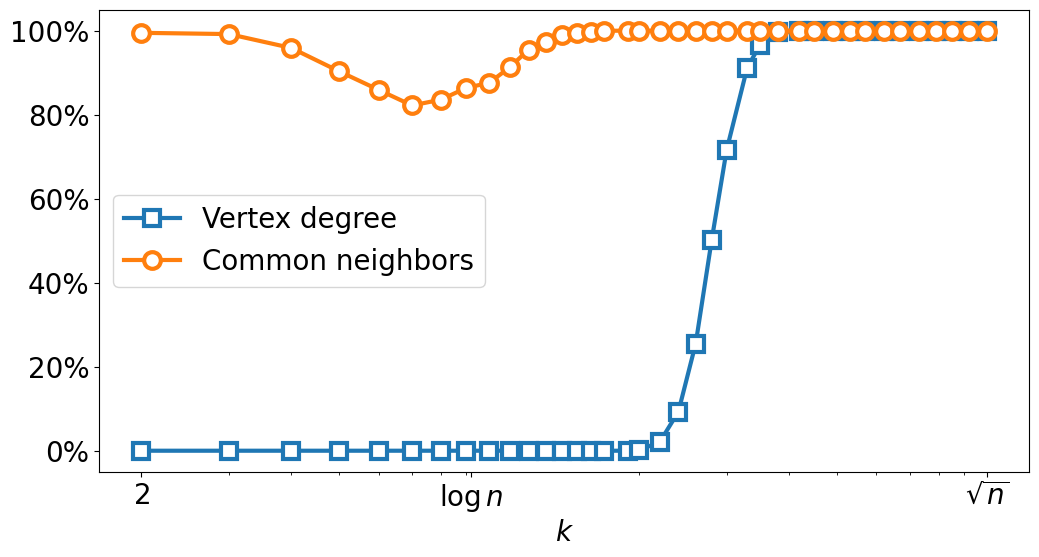

In [ ]:
# Parameters
n = 10000
mu = 20 #np.log(n)
r = np.sqrt(mu/(np.pi*n))

print(f"mu = {round(mu, 2)}")

k_values = np.logspace(np.log10(2), np.log10(np.sqrt(n)), 50)
k_values = np.unique(np.round(k_values).astype(int))    # Different sizes of the planted clique

num_graphs = 1000              # Number of graphs to generate

VD, CN = success_rates(n, mu, r, k_values, num_graphs)
plot_success_rates(VD, CN, k_values, n, mu)